In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils_BL as rl_utils

In [2]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        # 第一个隐藏层
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # self.fc1 = nn.Sequential(
        #     nn.Linear(state_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        self.fc_hidden1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        # self.fc_hidden4 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )       
        # 输出层，输出一个值，所以神经元数量为1
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x =self.fc_hidden1(x)
        x = self.fc_hidden2(x)
        x = self.fc_hidden3(x)
        # x = F.relu(self.fc_hidden4(x))
        return self.fc2(x)

class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # self.fc1 = nn.Sequential(
        #     nn.Linear(state_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        self.fc_hidden1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        # self.fc_hidden4 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )       
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc_hidden1(x)
        x = self.fc_hidden2(x)
        x = self.fc_hidden3(x)
        # x = F.relu(self.fc_hidden4(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

In [3]:
# class PolicyNetContinuous(torch.nn.Module):
#     def __init__(self, state_dim, hidden_dim, action_dim):
#         super(PolicyNetContinuous, self).__init__()
#         self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
#         # 新增的第一个隐藏层
#         self.fc_hidden1 = torch.nn.Linear(hidden_dim, hidden_dim)
#         # 新增的第二个隐藏层
#         self.fc_hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
#         # 新增的第三个隐藏层
#         self.fc_hidden3 = torch.nn.Linear(hidden_dim, hidden_dim)
#         # 新增的第四个隐藏层
#         self.fc_hidden4 = torch.nn.Linear(hidden_dim, hidden_dim)
#         self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
#         self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc_hidden1(x))
#         x = F.relu(self.fc_hidden2(x))
#         x = F.relu(self.fc_hidden3(x))
#         x = F.relu(self.fc_hidden4(x))
#         mu = 2.0 * torch.tanh(self.fc_mu(x))
#         std = F.softplus(self.fc_std(x))
#         return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    # def take_action(self, state):
    #     state = torch.tensor([state], dtype=torch.float).to(self.device)
    #     mu, sigma = self.actor(state)
    #     action_dist = torch.distributions.Normal(mu, sigma)
    #     action = action_dist.sample()
    #     return [action.item()]
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        if action.dim() > 1 and action.size(0) == 1:
            action = action.squeeze(0)
        return action.detach().cpu().tolist()
         # 将张量转换为numpy数组返回，方便后续在环境中使用

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

参数设计记录：


2. `actor_lr = 5e-5 critic_lr = 5e-5` num_episodes = 500 hidden_dim = 64 gamma = 0.9 lmbda = 0.9 `epochs = 50` eps = 0.1 hide=3 成功率 2%‘
2. `actor_lr = 5e-5 critic_lr = 5e-5` num_episodes = 500 hidden_dim = 64 gamma = 0.9 lmbda = 0.9 `epochs = 100` eps = 0.1 hide=3 成功率 2%
2. `actor_lr = 5e-6 critic_lr = 5e-6` num_episodes = 500 hidden_dim = 64 gamma = 0.9 lmbda = 0.9 `epochs = 100` eps = 0.1 hide=3 成功率 4%
2. `actor_lr = 5e-6 critic_lr = 5e-6` num_episodes = 500` hidden_dim = 128` gamma = 0.9 lmbda = 0.9 `epochs = 100` `eps = 0.3` hide=3 成功率 2%
2. `actor_lr = 5e-10 critic_lr = 5e-10` num_episodes = 500` hidden_dim = 128` gamma = 0.9 lmbda = 0.9 `epochs = 10` `eps = 0.3` hide=3 成功率 不行
2. `actor_lr = 5e-4 critic_lr = 5e-4` num_episodes = 500` hidden_dim = 64` gamma = 0.9 lmbda = 0.9 `epochs = 10` `eps = 0.3` hide=3 成功率 学习率太小
2. `actor_lr = 5e-5 critic_lr = 5e-5` num_episodes = 500` hidden_dim = 64` gamma = 0.9 lmbda = 0.8 `epochs = 10` `eps = 0.3` hide=3 成功率 学习率太小 
2. `actor_lr = 5e-6 critic_lr = 5e-6` num_episodes = 500` hidden_dim = 64` gamma = 0.9 lmbda = 0.8 `epochs = 10` `eps = 0.3` hide=3 成功率 3%

In [4]:
from env.water_env_ppo import FlowEnv as lenv
actor_lr = 5e-6
critic_lr = 5e-6
num_episodes = 500
hidden_dim = 64
gamma = 0.9
lmbda = 0.8
epochs = 200
eps = 0.1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
levelcount = 2
turn_max_time = 5
flow_erro = 0.05 #误差5%
meted='PPO'

env = lenv(levelcount = levelcount, turn_time=turn_max_time,flow_erro =flow_erro,adjust_max_count=200,meted='PPO')  
# env.seed(0)
# torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Jinzhao_hu\AppData\Local\Temp\ipykernel_32724\3838016049.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [33:57<00:00, 40.74s/it, episode=500, return=-1505.891]


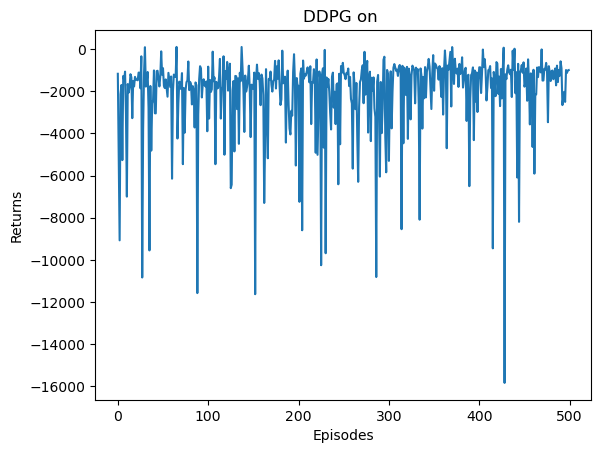

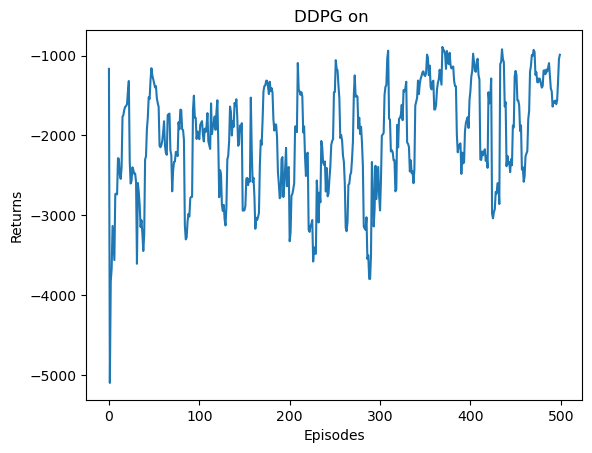

In [6]:
import pandas as pd

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(''))
plt.show()

# 创建一个字典，将数据整理成适合构建DataFrame的数据结构
data = {
    "Episodes": episodes_list,
    "Returns": return_list
}

# 使用字典创建DataFrame对象
df = pd.DataFrame(data)
# 创建只有一列数据的DataFrame
df = pd.DataFrame({"Returns": return_list})

# 将DataFrame保存为Excel文件，指定文件名为output.xlsx
df.to_excel(f"{levelcount}_PPO_reward.xlsx", index=False)

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(''))
plt.show()

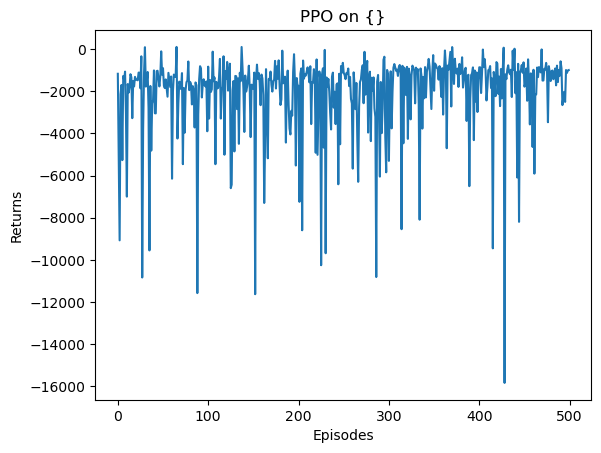

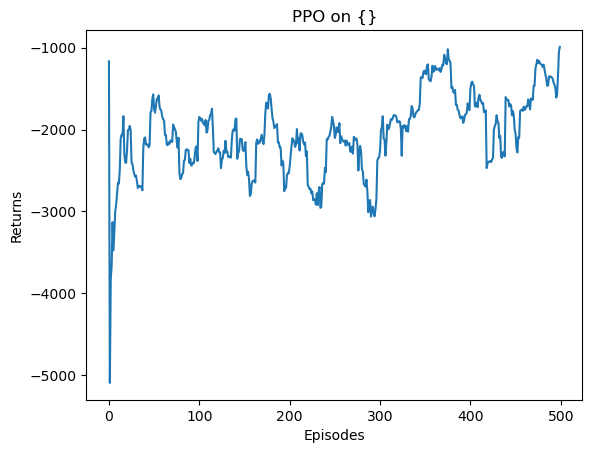

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}')
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}')
plt.show()

1.2 保存模型

In [208]:
torch.save(agent, f'model_{levelcount}_PPO.pt')

1.3 加载模型

In [209]:
levelcount = 2
metedName='PPO'

In [210]:
agent = torch.load(f'model_{levelcount}_PPO.pt')

1.4 仿真验证

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from env.water_env_ppo import FlowEnv as lenv

In [212]:


turn_max_time = 5
env = lenv(levelcount = levelcount, turn_time=turn_max_time, flow_erro=0.05,adjust_max_count=100, meted=metedName) 
# 
reward_list = np.array([])
Q_list = np.array([])
ta_list = np.array([])
#提取一个数据集
data = pd.read_excel(f'state_data_{levelcount}.xlsx')
# train_count = data.shape[0]
train_count = 99
for i in np.arange(train_count):
    data_row =np.array(data.iloc[i].values) 
    #data_row =np.array(data.iloc[59].values) 
    state =env.install(state =  data_row)
    done = False
    while not done:
        action = agent.take_action(state) #计算策略动作
        next_state, reward, done, _ = env.step(action)
        state = next_state
        reward_list = np.append(reward_list,reward)
    #翻译Q和ta
    temp_Qlist = np.array([])
    temp_ta = np.array([])
    sate_tran = env.trans_state(state)
    for i in np.arange(levelcount):
        temp_Qlist = np.append(temp_Qlist,sate_tran[4+i*5])
        temp_ta = np.append(temp_ta,sate_tran[5+i*5])      
    Q_list = np.concatenate((Q_list,temp_Qlist),axis=0)
    ta_list = np.concatenate((ta_list,temp_ta),axis=0)
Q_list = Q_list.reshape(-1,levelcount)
ta_list = ta_list.reshape(-1,levelcount)
# print (f'Q:{Q_list}')
# print (f'ta:{ta_list}')
# # print (f'ta:{reward_list}')

1.4.1 奖励函数

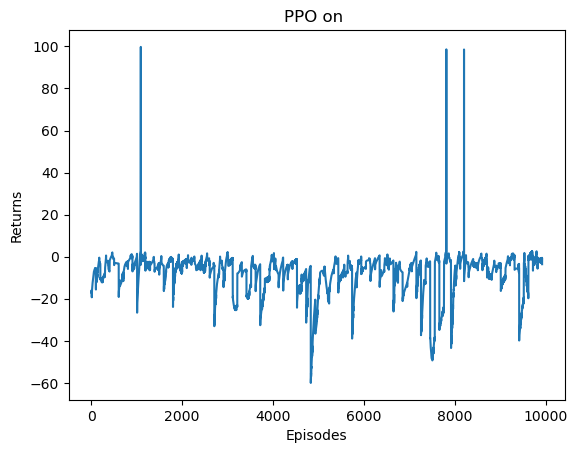

In [213]:
episodes_list = list(range(len(reward_list)))
plt.plot(episodes_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(''))
plt.show()

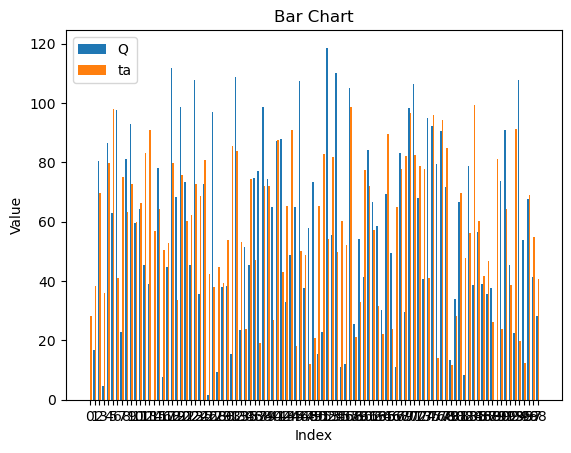

误差:0.6242114083511084


In [214]:
# 示例数据
# x = np.arange(train_count)
y1 = Q_list  # 第一组数据
y2 = ta_list  # 第二组数据

# 设置柱体的宽度
x = np.arange(y1.shape[0])
# Set width for bars
width = 0.35

# Plot y1 and y2 together
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1[:,0], width, label='Q')
rects2 = ax.bar(x + width/2, y2[:,0], width, label='ta')
# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Bar Chart')
ax.set_xticks(x)
ax.legend()

plt.show()
#平均误差
result =np.abs(y2-y1)/y2
# print(result)
# erro_avr =np.mean(np.sum(result)) 
erro_avr =np.sum(result)/(train_count*levelcount)  
print(f'误差:{erro_avr}')
df = pd.DataFrame(result)
df.to_excel(f'{levelcount}_{metedName}_errodata.xlsx', index=False,header=False)

1.4.3 调整平均次数

In [215]:
from openpyxl import load_workbook

# 打开Excel文件
workbook = load_workbook(f'{levelcount}_PPO_RL_done.xlsx')

# 获取第一个工作表
sheet = workbook.active
# 从第二行开始，遍历第一列的所有单元格，取值并求和

sum_value = 0
count = 0
for row in sheet.iter_rows(min_row=2, min_col=1, max_col=1, values_only=True):
   if row[0] is not None and row[0] != 100:
        sum_value += row[0]
        count += 1
# 计算平均值
if count>0 :  
  average = sum_value / count
  print("和：", sum_value)
  print("平均值：", average)
  print('成功率：',count/train_count)

和： 218
平均值： 72.66666666666667
成功率： 0.030303030303030304
